# Project 3: 

## Imports and Data Setup

In [1]:
#Standard imports as needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

#Processing data and related
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

#models and related
from sklearn.linear_model import LinearRegression
from sklearn.kernel_approximation import Nystroem 
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.optim as optim


#Various metrics and related
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, accuracy_score
import math

In [2]:
#set up our original data and read in processed data
housing = pd.read_csv("for_labels.csv") #following steps from earlier
data = pd.read_csv("processed_data.csv")

## Linear Regression: 

In [3]:
processed_X = data.loc[:, ~data.columns.isin(["median_house_value", "longitude", "latitude"])]
y = housing[["median_house_value"]]

X_train, X_test, y_train, y_test = train_test_split(processed_X, y, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train, test_size = 0.2)

In [4]:
#Standard Multi Linear 
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_valid = linear_model.predict(X_validation)

print(f'Mean Squared Error on the Validation: {np.mean((y_validation-y_pred_valid)**2)}')

Mean Squared Error on the Validation: 3773658148.3596926


In [5]:
#Ridge Regression w/ kernel trick (Gaussian Kernel)
#hyper parameters 
gamma_tested = {.075: 39871, .1: 39973}

alpha_hyper = .25
gamma_hyper = 0.09

#Sets up Kernel Approximation for Gaussian 
nystroem_gauss = Nystroem(kernel="rbf", gamma= gamma_hyper, n_components=250)
X_train_nystroem = nystroem_gauss.fit_transform(X_train)
X_validation_nystroem = nystroem_gauss.transform(X_validation)

#Train model
gauss = Ridge(alpha= alpha_hyper)
gauss.fit(X_train_nystroem, y_train)

#Predict model on validation set
y_pred_valid_gauss = gauss.predict(X_validation_nystroem)


mean_absolute_residual = np.mean(abs(y_validation - y_pred_valid_gauss))
mse_ridge = np.mean((y_validation-y_pred_valid_gauss)**2)
print(f"Mean Squared Error on the Validation: {mse_ridge}")



Mean Squared Error on the Validation: 3003677770.422478


In [6]:
#Ridge Regression w/ kernel trick (Polynomial Kernel)
#hyper parameters 
gamma_tested = {.075: 39871, .1: 39973}

alpha_hyper = .25
gamma_hyper = 0.1

nystroem_poly = Nystroem(kernel="poly", degree = 3, gamma= gamma_hyper, n_components=300)
X_train_nystroem = nystroem_poly.fit_transform(X_train)
X_validation_nystroem = nystroem_poly.transform(X_validation)

poly = Ridge(alpha= alpha_hyper)
poly.fit(X_train_nystroem, y_train)

y_pred_poly_valid = poly.predict(X_validation_nystroem)

mean_absolute_residual_poly = np.mean(abs(y_validation - y_pred_poly_valid))
mse_poly = np.mean((y_validation-y_pred_poly_valid)**2)
print(f"Mean Squared Error on the Validation: {mse_poly}")



Mean Squared Error on the Validation: 3353976870.087012


In [7]:
# EVALUATING TEST SETS

#Ordinary Multi Linear Regression
y_pred = linear_model.predict(X_test)
mse = np.mean((y_test - y_pred)**2)
rmse = mse**(1/2)
print(f"The Test set mean squared error of Ordinary Multi Linear Regression is: {mse}")
print(f"The Test set root mean square error of Ordinary Multi Linear Regression is: {rmse}\n")

#Sets up Kernel Approximation for Gaussian test set 
X_test_nystroem_gauss = nystroem_gauss.transform(X_test)
y_pred_gauss = gauss.predict(X_test_nystroem_gauss)
mse = np.mean((y_test - y_pred_gauss)**2)
rmse = mse**(1/2)
print(f"The Test set mean squared error of Ridge Regression with Gaussian Kernel is: {mse}")
print(f"The Test set root mean square error of Ridge Regression with Gaussian Kernel is is: {rmse}\n")


#Sets up Kernel Approximation for Polynomial test set
X_test_nystroem_poly = nystroem_poly.transform(X_test)
y_pred_poly = poly.predict(X_test_nystroem_poly)
mse = np.mean((y_test - y_pred_poly)**2)
rmse = mse**(1/2)
print(f"The Test set mean squared error of Ridge Regression with Polynomial Kernel (Degree 3) is: {mse}")
print(f"The Test set root mean square error of Ridge Regression with Polynomial Kernel (Degree 3) is: {rmse}")

The Test set mean squared error of Ordinary Multi Linear Regression is: 3731389825.1575546
The Test set root mean square error of Ordinary Multi Linear Regression is: 61085.10313617842

The Test set mean squared error of Ridge Regression with Gaussian Kernel is: 2999921855.429531
The Test set root mean square error of Ridge Regression with Gaussian Kernel is is: 54771.542386804584

The Test set mean squared error of Ridge Regression with Polynomial Kernel (Degree 3) is: 3085553609.93322
The Test set root mean square error of Ridge Regression with Polynomial Kernel (Degree 3) is: 55547.75972020132


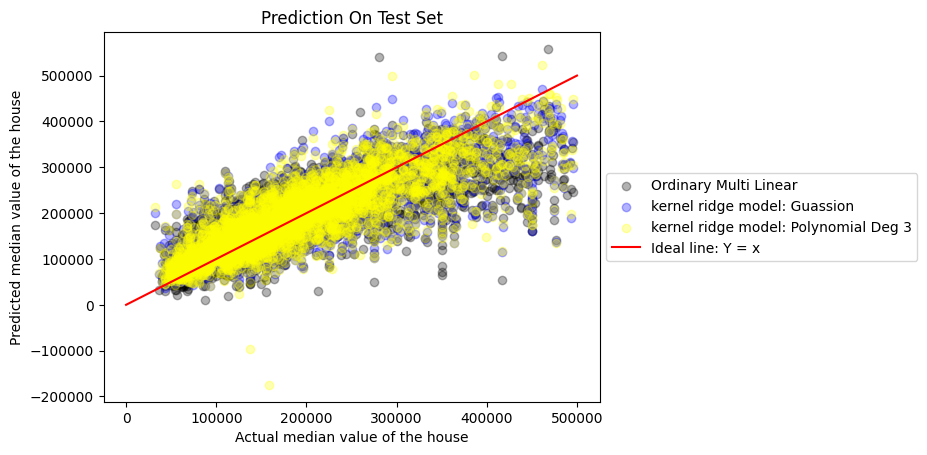

In [8]:
#Graphing
plt.scatter(x = y_test, y = y_pred, color = "black", label = "Ordinary Multi Linear", alpha = .3)
plt.scatter(x = y_test, y = y_pred_gauss, color = "blue", label = "kernel ridge model: Guassion", alpha = .3)
plt.scatter(x = y_test, y = y_pred_poly, color = "Yellow", label = "kernel ridge model: Polynomial Deg 3", alpha = .3)

x_line = np.linspace(0,500000,2)
plt.plot(x_line, x_line, color = "red", label = "Ideal line: Y = x") #ideally this line  is what our predictions are centered around
plt.xlabel("Actual median value of the house"); plt.ylabel("Predicted median value of the house")
plt.title("Prediction On Test Set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Support Vector Machines

In [9]:
def eval_classification_model(model,X_test,y_test):
    '''
    Should be used for models where the purpose is classification
    Takes the model, makes predictions and then finds accuracy counts:
    Can be used for both validation or test sets
    '''
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    return accuracy

In [10]:
processed_X = data.drop(columns = ["ocean_proximity_<1H OCEAN", "ocean_proximity_INLAND",
                                    "ocean_proximity_NEAR BAY", "ocean_proximity_NEAR OCEAN"]) #notice svms still need longitude and latititude to make them somewhat decent
y = housing[["ocean_proximity"]]

X_train, X_test, y_train, y_test = train_test_split(processed_X, y, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train, test_size = .2)

In [11]:
#Hyper-params
gamma_hyper = .1
reg = .2

svm_gauss = SVC(kernel = "rbf", C = reg, gamma = gamma_hyper, class_weight = "balanced")
svm_gauss.fit(X_train, y_train.values.ravel())

acc_gauss = eval_classification_model(svm_gauss, X_validation, y_validation)
print(f"The accuracy of this model is: {np.round(acc_gauss,4)}")

The accuracy of this model is: 0.8158


In [12]:
#Hyper-params
gamma_hyper = .02
degree_hyper = 3
reg = .3

svm_poly = SVC(kernel = "poly", C = reg, gamma = gamma_hyper, degree= degree_hyper, class_weight = "balanced")
svm_poly.fit(X_train, y_train.values.ravel())

acc_poly = eval_classification_model(svm_poly, X_validation, y_validation)
print(f"The accuracy of this model is: {np.round(acc_poly,4)}")

The accuracy of this model is: 0.8431


In [13]:
#Evaluating Everything on Test Sets:
models = [svm_gauss, svm_poly]
model_names = ["support vector machine (gaussian kernel)", "support vector machine (polynomial kernel deg 3)"]
i = 0
for model in models:
    acc = eval_classification_model(model, X_test, y_test)
    print(f"The Accuracy of {model_names[i]} on the test set is: {acc}")
    i += 1



The Accuracy of support vector machine (gaussian kernel) on the test set is: 0.8207765492414503
The Accuracy of support vector machine (polynomial kernel deg 3) on the test set is: 0.8536898945744408


## Decision Trees and Random Forests

In [14]:
#Start by splitting data
processed_X = data.drop(columns = ["ocean_proximity_<1H OCEAN", "ocean_proximity_INLAND",
                                    "ocean_proximity_NEAR BAY", "ocean_proximity_NEAR OCEAN",
                                    "longitude", "latitude"]) #no longtitude/latitude bc it makes it too easy for this model
y = housing[["ocean_proximity"]]

X_train, X_test, y_train, y_test = train_test_split(processed_X, y, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train, test_size = .2)

dec_tree = tree.DecisionTreeClassifier()
dec_tree = dec_tree.fit(X_train, y_train)

print(f"The Training accuracy on the default model (No Hyper Parameters) is: {eval_classification_model(dec_tree,X_train,y_train) }")
print(f"The validation accuracy on the default model (No Hyper Parameters) is: {eval_classification_model(dec_tree,X_validation,y_validation)}")

The Training accuracy on the default model (No Hyper Parameters) is: 1.0
The validation accuracy on the default model (No Hyper Parameters) is: 0.569270331083253


In [15]:
#Lets tune hyper-parameters

#hypers: Search for using the grid_search module in scikit
param_grid = {
    'max_depth': [7,8,9],   
    'min_samples_split': [2,3,4], 
    'min_samples_leaf': [20,21,22,23,24,25],
    'ccp_alpha': [0, .05, .075, .025]
}

dec_tree_hypers = tree.DecisionTreeClassifier()
dec_tree_grid = GridSearchCV(estimator = dec_tree_hypers, param_grid = param_grid, cv = 4, scoring='accuracy', n_jobs=-1, verbose=1)
dec_tree_grid.fit(X_train, y_train)

#Evaluation of Model
print(f"Best hyperparameters found: {dec_tree_grid.best_params_}")
best_model = dec_tree_grid.best_estimator_
valid_accuracy = best_model.score(X_validation, y_validation)
print(f"Validation accuracy with said hyperparameters: {valid_accuracy} ")


Fitting 4 folds for each of 216 candidates, totalling 864 fits
Best hyperparameters found: {'ccp_alpha': 0, 'max_depth': 7, 'min_samples_leaf': 21, 'min_samples_split': 2}
Validation accuracy with said hyperparameters: 0.6460945033751205 


In [16]:
best_tree = tree.DecisionTreeClassifier(ccp_alpha = dec_tree_grid.best_params_['ccp_alpha'],
                                   max_depth = dec_tree_grid.best_params_['max_depth'],
                                   min_samples_leaf = dec_tree_grid.best_params_['min_samples_leaf'],
                                  min_samples_split = dec_tree_grid.best_params_['min_samples_split']
                                  )
best_tree.fit(X_train,y_train)

print(f"The Training accuracy on the best found parameters is: {eval_classification_model(best_tree,X_train,y_train)}")
print(f"The validation accuracy on the best found parameters is: {eval_classification_model(best_tree,X_validation,y_validation)}")
print(f"The test accuracy on the best found parameters is: {eval_classification_model(best_tree,X_test,y_test)}")

The Training accuracy on the best found parameters is: 0.6708189343405931
The validation accuracy on the best found parameters is: 0.6460945033751205
The test accuracy on the best found parameters is: 0.652867060941116


#### Random Forests

In [17]:
random_forest_default = RandomForestClassifier()
random_forest_hypers = RandomForestClassifier(n_estimators = 100, ccp_alpha = dec_tree_grid.best_params_['ccp_alpha'],
                                   max_depth = dec_tree_grid.best_params_['max_depth'],
                                   min_samples_leaf = dec_tree_grid.best_params_['min_samples_leaf'],
                                  min_samples_split = dec_tree_grid.best_params_['min_samples_split']
                                  )

random_forest_default.fit(X_train, y_train.values.ravel())
random_forest_hypers.fit(X_train, y_train.values.ravel()) #unraveling dataframe bc warning comment warns this is needed

validation_default = eval_classification_model(random_forest_default,X_validation, y_validation)
validation_hypers = eval_classification_model(random_forest_hypers,X_validation, y_validation)

print(f"The validation accuracy on the default model (No Hyper Parameters) is: {validation_default}")
print(f"The validation accuracy on a tuned model (from decision trees) is: {validation_hypers}")

The validation accuracy on the default model (No Hyper Parameters) is: 0.681131468981035
The validation accuracy on a tuned model (from decision trees) is: 0.6711668273866924


In [18]:
random_forest_grid = GridSearchCV(estimator = dec_tree_hypers, param_grid = param_grid, cv = 4, scoring='accuracy', n_jobs=-1, verbose=1)

param_grid = {
    'max_depth': [8],   # Maximum depth of the tree
    'min_samples_split': [2,3,4],   # Minimum number of samples to split an internal node
    'min_samples_leaf': [20,21,22,23,24],     # Minimum number of samples at a leaf node
    'ccp_alpha': [0, .075, .025]
}

random_forest_grid.fit(X_train, y_train)

print(f"Best hyperparameters found: {random_forest_grid.best_params_}")
best_model = random_forest_grid.best_estimator_
valid_accuracy = best_model.score(X_validation, y_validation)
print(f"Validation accuracy with said hyperparameters: {valid_accuracy} ")


Fitting 4 folds for each of 216 candidates, totalling 864 fits
Best hyperparameters found: {'ccp_alpha': 0, 'max_depth': 7, 'min_samples_leaf': 21, 'min_samples_split': 2}
Validation accuracy with said hyperparameters: 0.6460945033751205 


In [19]:
best_forest = RandomForestClassifier(ccp_alpha = random_forest_grid.best_params_['ccp_alpha'],
                                   max_depth = random_forest_grid.best_params_['max_depth'],
                                   min_samples_leaf = random_forest_grid.best_params_['min_samples_leaf'],
                                  min_samples_split = random_forest_grid.best_params_['min_samples_split']
                                  )
best_forest.fit(X_train,y_train.values.ravel())

print(f"The Training accuracy on the best found parameters is: {eval_classification_model(best_forest,X_train,y_train)}")
print(f"The validation accuracy on the best found parameters is: {eval_classification_model(best_forest,X_validation,y_validation)}")
print(f"The test accuracy on the best found parameters is: {eval_classification_model(best_forest,X_test,y_test)}")

The Training accuracy on the best found parameters is: 0.6772482520292534
The validation accuracy on the best found parameters is: 0.6702025072324012
The test accuracy on the best found parameters is: 0.6706094111596812


## Neural Network For Regression

In [20]:
#Processing Data For Regression Task
processed_X = data.loc[:, ~data.columns.isin(["median_house_value"])]
y = housing[["median_house_value"]]

# Convert to tensor
processed_X = torch.from_numpy(processed_X.values).type(torch.float)
y = torch.from_numpy(y.values).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(processed_X, y, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train, test_size = 0.2)
len(X_train[0])

14

In [21]:
#Build model In Fashion from what we did in project 2:
#input size should be 14 because we have 14 features
#output should be a linear layer of size 1 (predicting regression)
# Define the model
class RegressionNetwork(nn.Module):
    def __init__(self, input_size = 14, output_size = 1):
        super().__init__()    
        self.fc_1 = nn.Linear(input_size, 128)
        self.fc_2 = nn.Linear(128, 64)
        self.fc_3 = nn.Linear(64,20)
        self.fc_4 = nn.Linear(20,output_size)
        self.relu = nn.ELU() #found this online, solving my vanishing gradient problems
        #Attempt to find other solutions because this makes model significantly worse
        
    def forward(self, x):
        x = self.relu(self.fc_1(x))
        x = self.relu(self.fc_2(x))
        x = self.relu(self.fc_3(x))
        x = self.relu(self.fc_4(x))
        return x 

#Implement Training from proj2, loss_fn is always mse in our case of regression
def train_step(model, X_train, y_train, optimizer, device):
    model.train()
    #move to device
    X_train, y_train = X_train.to(device), y_train.to(device) #Don't forget to convert  
                                                    #X and y_train to tensors when passing in
    
    #to loss function CE in this case 
    y_pred = model(X_train)
    loss = nn.MSELoss()(y_pred, y_train)

    #compute RMSE
    rmse = torch.sqrt(loss)
    
    # Update step from slides
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, rmse

def evaluation_step(model, X_test, y_test, device):
    #move to device
    with torch.no_grad():
        X_test, y_test = X_test.to(device), y_test.to(device)
    
        #Compute your loss function
        y_test_pred = model(X_test)
        loss = nn.MSELoss()(y_test_pred, y_test)
        
        #compute RMSE
        rmse = torch.sqrt(loss)

    return loss, rmse

def train_simple_model(X_train, y_train, X_valid, y_valid, X_test, y_test, random_seed, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(random_seed) # do not change this
    simple_model = RegressionNetwork().to(device)
    opt = torch.optim.Adam(simple_model.parameters(), lr = 0.007)
    simple_model.train()

    train_rmse_list = []
    train_loss_list = []
    test_rmse_list = []
    test_loss_list = []
    valid_rmse_list = []
    valid_loss_list = []
    
    for epoch in range(epochs):
        loss, rmse = train_step(simple_model, X_train, y_train, opt, device)
        train_rmse_list.append(rmse.item()) 
        train_loss_list.append(loss.item())

        valid_loss, valid_rmse = evaluation_step(simple_model, X_valid, y_valid, device)
        valid_loss_list.append(valid_loss.item())
        valid_rmse_list.append(valid_rmse.item())
        
        test_loss, test_rmse = evaluation_step(simple_model, X_test, y_test, device)
        test_loss_list.append(test_loss.item())
        test_rmse_list.append(test_rmse.item())
        
        if epoch % 1000 == 0:
            print(f"Epoch: {epoch}, Train Loss: {loss}, Train RMSE: {rmse}")
            print(f"\t   validation loss: {valid_loss}, Test RMSE {valid_rmse}")
            print(f"\t   Test loss: {test_loss}, Test RMSE {test_rmse}\n")

    return simple_model, train_loss_list, train_rmse_list, test_loss_list, test_rmse_list, valid_loss_list, valid_rmse_list

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 6001
train_losses = np.zeros(num_epochs)
train_rmses = np.zeros(num_epochs)
valid_losses = np.zeros(num_epochs)
valid_rmses = np.zeros(num_epochs)
test_losses = np.zeros(num_epochs)
test_rmses = np.zeros(num_epochs)

for i in range(1,10):
    print(f"We're in iteration {i}")
    random_seed = i
    model, train_loss, train_rmse,  test_loss, test_rmse, valid_loss, valid_rmse = train_simple_model(X_train, y_train, X_validation, y_validation, X_test, y_test, random_seed,num_epochs)
    train_losses = np.vstack((train_losses, train_loss))
    train_rmses = np.vstack((train_rmses, train_rmse))
    valid_losses = np.vstack((valid_losses, valid_loss))
    valid_rmses = np.vstack((valid_rmses, valid_rmse))
    test_losses = np.vstack((test_losses, test_loss))
    test_rmses = np.vstack((test_rmses, test_rmse))
    i += 1

#Getting rid of that first row of zeroes and averaging across all of the random seeds 
averaged_train_losses = np.mean(train_losses[1:,:] ,axis = 0)
averaged_train_rmses = np.mean(train_rmses[1:, :], axis = 0)
averaged_test_losses = np.mean(test_losses[1:, :], axis = 0)
averaged_test_rmses = np.mean(test_rmses[1:, :], axis = 0)
averaged_valid_losses =  np.mean(valid_losses[1:, :], axis = 0)
averaged_valid_rmses =  np.mean(valid_rmses[1:, :], axis = 0)

We're in iteration 1
Epoch: 0, Train Loss: 46457163776.0, Train RMSE: 215539.234375
	   validation loss: 46260391936.0, Test RMSE 215082.296875
	   Test loss: 45675311104.0, Test RMSE 213717.828125

Epoch: 1000, Train Loss: 3180943616.0, Train RMSE: 56399.85546875
	   validation loss: 3189118208.0, Test RMSE 56472.27734375
	   Test loss: 3071637504.0, Test RMSE 55422.35546875

Epoch: 2000, Train Loss: 2852304896.0, Train RMSE: 53406.97265625
	   validation loss: 2958797056.0, Test RMSE 54394.82421875
	   Test loss: 2846417408.0, Test RMSE 53351.828125

Epoch: 3000, Train Loss: 2641474560.0, Train RMSE: 51395.27734375
	   validation loss: 2797738496.0, Test RMSE 52893.65234375
	   Test loss: 2673866240.0, Test RMSE 51709.44140625

Epoch: 4000, Train Loss: 2503456000.0, Train RMSE: 50034.546875
	   validation loss: 2719246848.0, Test RMSE 52146.3984375
	   Test loss: 2600221696.0, Test RMSE 50992.3671875

Epoch: 5000, Train Loss: 2430945280.0, Train RMSE: 49304.6171875
	   validation los

In [23]:
print(f"The average ending (last epoch) train losses across 10 seeds is: {averaged_train_losses[-1]}")
print(f"The average ending (last epoch) train rmse across 10 seeds is: {averaged_train_rmses[-1]}")
print(f"The average ending (last epoch) validation losses across 10 seeds is: {averaged_valid_losses[-1]}")
print(f"The average ending (last epoch) validation rmse across 10 seeds is: {averaged_valid_rmses[-1]}")
print(f"The average ending (last epoch) test losses across 10 seeds is: {averaged_test_losses[-1]}")
print(f"The average ending (last epoch) test rmse across 10 seeds is: {averaged_test_rmses[-1]}")


The average ending (last epoch) train losses across 10 seeds is: 2413910044.4444447
The average ending (last epoch) train rmse across 10 seeds is: 49129.578993055555
The average ending (last epoch) validation losses across 10 seeds is: 2704116024.888889
The average ending (last epoch) validation rmse across 10 seeds is: 52000.69965277778
The average ending (last epoch) test losses across 10 seeds is: 2561472227.5555553
The average ending (last epoch) test rmse across 10 seeds is: 50610.57638888889


In [24]:
def plot_loss_performance(train_losses, test_losses, valid_losses):
    epochs = np.linspace(1, len(train_losses), len(train_losses))
    plt.plot(epochs,valid_losses, label = "Validation Set Losses", c= "green")
    plt.plot(epochs,train_losses, label = "Train Set Losses", c= "red")
    plt.plot(epochs,test_losses, label = "Test Set Losses", c = "blue")
    plt.xlabel("Epoch Number"); plt.ylabel("Mean Squared Error"); plt.title("Average MSE in Train vs Test Sets (Seeds 1-10)")
    plt.ylim(2000000000,10000000000)
    plt.legend()

def plot_accuracy_performance(train_rmse, test_rmse, valid_rmse):
    epochs = np.linspace(1, len(train_rmse), len(train_rmse))
    plt.plot(epochs,valid_rmse, label = "Validation Set Losses", c= "green")
    plt.plot(epochs,train_rmse, label = "Train RMSE", c= "red")
    plt.plot(epochs,test_rmse, label = "Test RMSE", c = "blue")
    plt.xlabel("Epoch Number"); plt.ylabel("Root Mean Squared Error"); plt.title("Average RMSE in Train vs Test Sets (Seeds 1-10)")
    plt.legend()

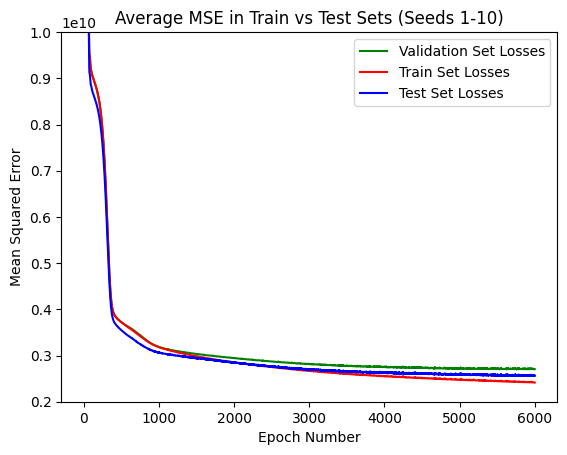

In [25]:
plot_loss_performance(averaged_train_losses, averaged_test_losses, averaged_valid_losses)

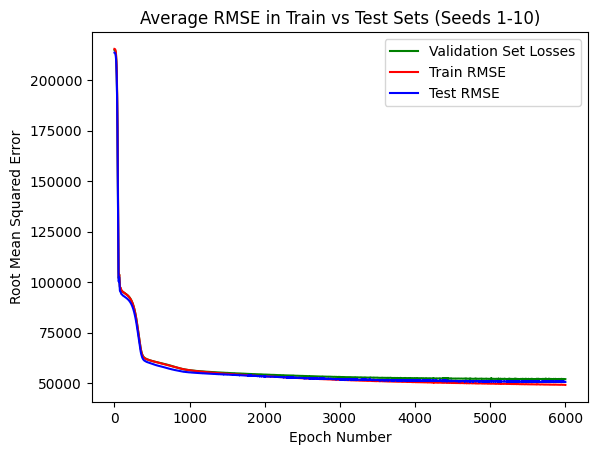

In [26]:
plot_accuracy_performance(averaged_train_rmses, averaged_test_rmses, averaged_valid_rmses)